In [1]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
#import matplotlib.pyplot as plt

path = Path('/mnt/c/School/Scripts/TestData/')

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python       : 3.7.1
fastai       : 1.0.51
fastprogress : 0.1.20
torch        : 1.0.1.post2
torch cuda   : 10.0.130 / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Linux-4.4.0-17134-Microsoft-x86_64-with-debian-buster-sid
distro       : #523-Microsoft Mon Dec 31 17:49:00 PST 2018
conda env    : Unknown
python       : /home/thor/anaconda3/bin/python
sys.path     : /mnt/c/School/Scripts
/home/thor/anaconda3/lib/python37.zip
/home/thor/anaconda3/lib/python3.7
/home/thor/anaconda3/lib/python3.7/lib-dynload

/home/thor/anaconda3/lib/python3.7/site-packages
/home/thor/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/thor/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once

In [3]:
path.ls()

[PosixPath('/mnt/c/School/Scripts/TestData/codes.txt'),
 PosixPath('/mnt/c/School/Scripts/TestData/images'),
 PosixPath('/mnt/c/School/Scripts/TestData/masks'),
 PosixPath('/mnt/c/School/Scripts/TestData/models'),
 PosixPath('/mnt/c/School/Scripts/TestData/valid.txt')]

In [4]:
path_lbl = path/'masks'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/mnt/c/School/Scripts/TestData/images/MAGNA_23_-1CL_5.74701e-06kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/images/MAGNA_24_86.4671CL_3.19876kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/images/MAGNA_25_83.5527CL_3.51574kg.tif')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/mnt/c/School/Scripts/TestData/masks/MAGNA_23_-1CL_5.74701e-06kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/masks/MAGNA_24_86.4671CL_3.19876kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/masks/MAGNA_25_83.5527CL_3.51574kg.tif')]

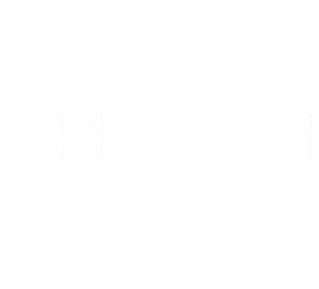

In [7]:
## Data

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
#plt.show()

In [8]:
img_f.parent.parent

PosixPath('/mnt/c/School/Scripts/TestData')

/mnt/c/School/Scripts/TestData/images
[700 768] tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


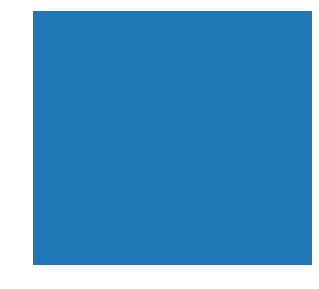

In [9]:
# TODO Continue from here...
def get_y_fn(x):
    print(str(x.parent))
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
#plt.show()

src_size = np.array(mask.shape[1:])
print(src_size, mask.data)

In [10]:
## Datasets
bs,size = 4,src_size//2

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('/mnt/c/School/Scripts/TestData/valid.txt')
       .label_from_func(get_y_fn, classes=codes))

/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/Schoo

In [11]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

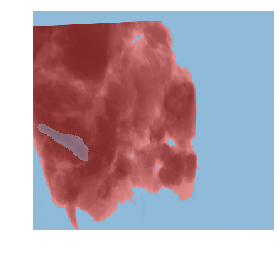

In [12]:
data.show_batch(1)#, figsize=(10,7))
#plt.show()

In [13]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [14]:
metrics=acc_camvid

In [15]:
wd=1e-2

In [16]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [17]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


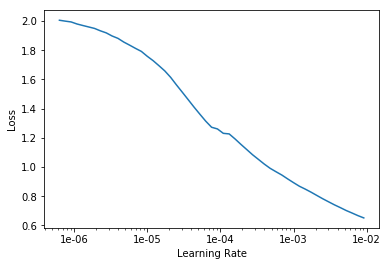

In [18]:
learn.recorder.plot()

In [19]:
lr=1e-4

In [20]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.324630,0.695703,0.797346,05:37
1,0.738175,0.179689,0.937976,05:53
2,0.458979,0.081747,0.982368,04:56
3,0.305746,0.045573,0.989375,04:59
4,0.224086,0.037459,0.988398,05:06
5,0.167217,0.031667,0.990556,05:07
6,0.135371,0.038558,0.991458,05:07
7,0.104933,0.025965,0.992007,05:03
8,0.082823,0.024412,0.992096,04:58
9,0.067559,0.020185,0.994102,04:57


In [21]:
learn.save('stage-1-big')

In [22]:
learn.load('stage-1-big');

In [23]:
learn.unfreeze()

In [24]:
lrs = slice(1e-6,lr/10)

In [25]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.028535,0.019660,0.994408,05:13
1,0.029042,0.019662,0.994286,05:15
2,0.030821,0.018029,0.995011,05:16
3,0.030751,0.018273,0.994771,05:08
4,0.029822,0.017956,0.994866,05:11
5,0.029520,0.017343,0.995337,05:07
6,0.028793,0.019204,0.994001,05:12
7,0.027719,0.016784,0.995303,05:17
8,0.027058,0.016837,0.995238,05:17
9,0.025985,0.016935,0.995190,05:19


In [26]:
learn.save('stage-2-big')

In [27]:
learn.load('stage-2-big');

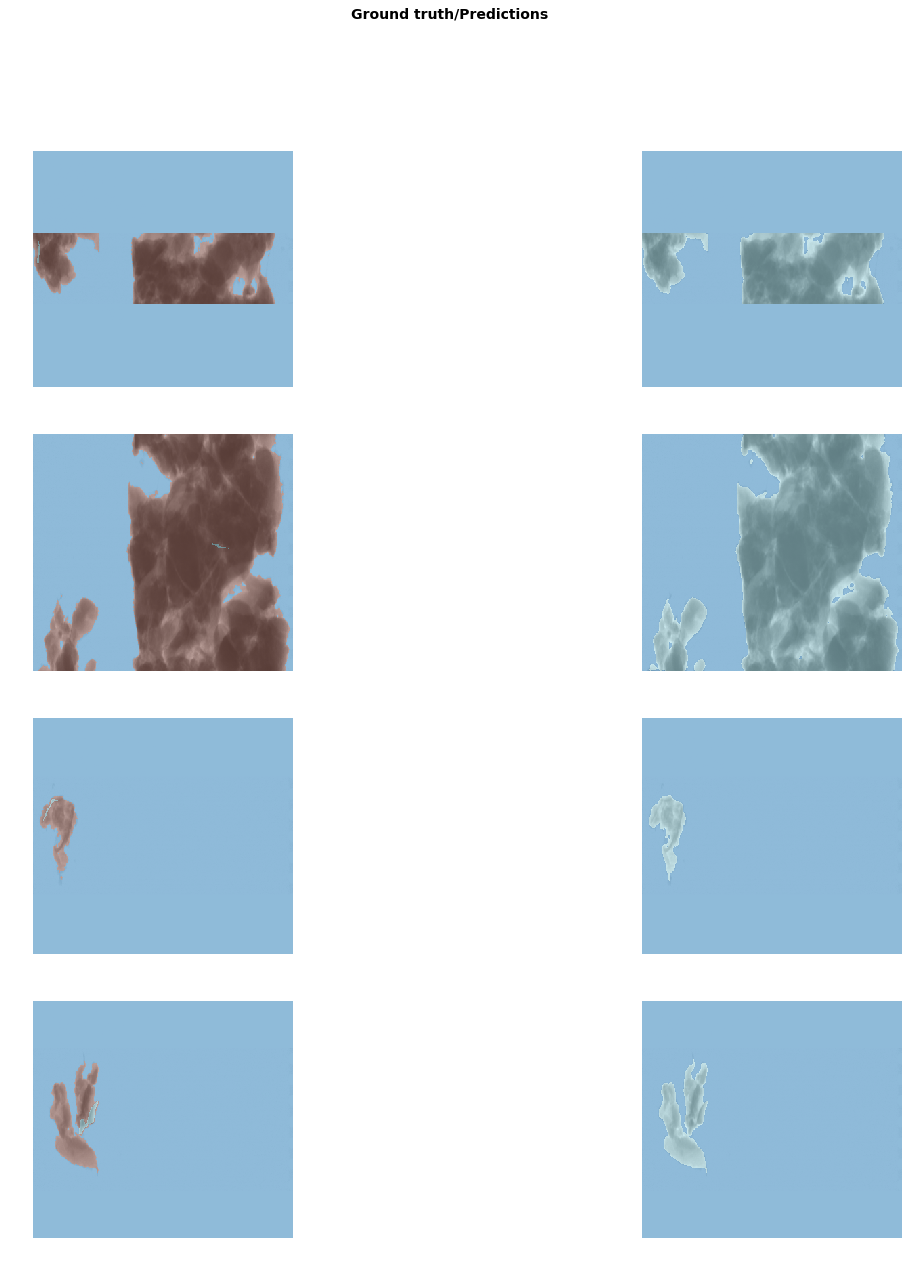

In [32]:
learn.show_results(rows=8, figsize=(20,20))